In [211]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from experiments.SL_bound import *
from experiments.DA_bound import *
from bounds.bounds import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
task = 2

results_folder = "/cephyr/users/frejohk/Alvis/projects/mnist_transfer/results/task2/Binary"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
r_files = [f for f in os.listdir(results_folder) if 'results.pkl' in f]

D = pd.DataFrame({})
for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0)

D['germain_bound'] = np.nan
D['beta_bound'] = np.nan

D.columns

Index(['Weightupdates', 'train_germain', 'target_germain', 'KL', 'e_s', 'e_t',
       'd_tx', 'd_sx', 'error_std', 'target_error_std', 'e_s_std', 'e_t_std',
       'd_tx_std', 'd_sx_std', 'alpha', 'sigma', 'epsilon', 'checkpoint',
       'delta', 'm_bound', 'm_target', 'seed', 'germain_bound', 'beta_bound'],
      dtype='object')

In [213]:
m_bound = D['m_bound'].values[0]
delta = D['delta'].values[0]
    
 # calculate disrho bound
for s in np.sort(D['sigma'].unique()):
    stratum = D['sigma']==s
    train_germain = D[stratum]['train_germain'].values
    e_s = D[stratum]['e_s'].values
    e_t = D[stratum]['e_t'].values
    d_tx = D[stratum]['d_tx'].values
    d_sx = D[stratum]['d_sx'].values
    KL = D[stratum]['KL'].values

    res, bestparam, boundparts = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL))
    res_inf, _, _ = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL))

    # calculate beta bound
    [res2, bestparam2, boundparts2] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL),beta_bound=True)
    [res2_inf, _, _] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL),beta_bound=True)
    
    I = D['sigma'] == s
    D.loc[I,'germain_bound'] = res
    D.loc[I,'beta_bound'] = res2
    D.loc[I,'germain_bound_inf'] = res_inf
    D.loc[I,'beta_bound_inf'] = res2_inf
    
    

Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....


,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,epsilon,checkpoint,delta,m_bound,m_target,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf
0,4923,0.052369,0.089506,395.868143,0.017371,0.039279,0.100454,0.069995,0.019222,0.028897,...,0.01,2_8,0.05,63009,69990,None,0.396540,0.619013,0.094051,0.241131
0,360,0.052306,0.110027,135.561264,0.048933,0.104066,0.011922,0.006747,0.000751,0.002338,...,0.01,1_360,0.05,63009,69990,None,0.186337,0.883263,0.085325,0.543677
0,8205,0.036132,0.063456,633.709032,0.009421,0.024409,0.078093,0.053423,0.014323,0.018359,...,0.01,2_14,0.05,63009,69990,None,0.535914,0.617023,0.068560,0.142581
0,270,0.057753,0.142556,25.958576,0.046666,0.120727,0.043658,0.022173,0.002771,0.011621,...,0.01,1_270,0.05,63009,69990,None,0.162137,0.675323,0.116551,0.534644
0,45,0.062783,0.143875,5.582011,0.059142,0.137207,0.013336,0.007281,0.000885,0.003791,...,0.01,1_45,0.05,63009,69990,None,0.144410,0.748138,0.108155,0.656577


Sigma = 0.00300


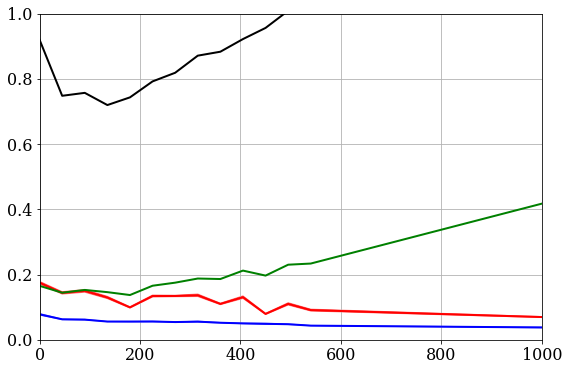

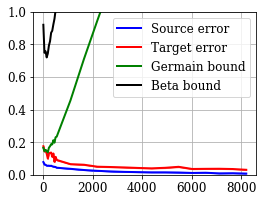

Sigma = 0.01000


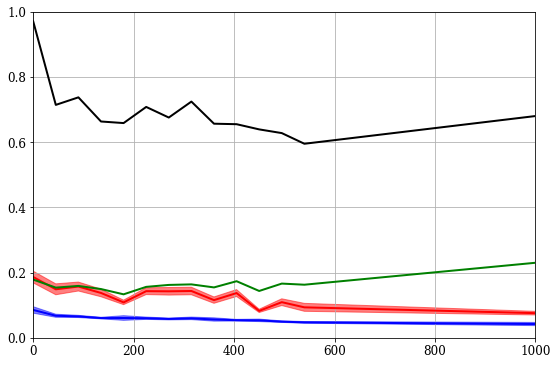

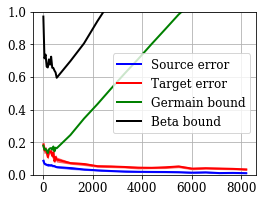

Sigma = 0.03000


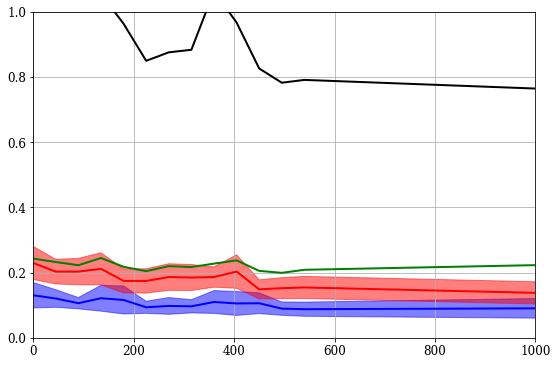

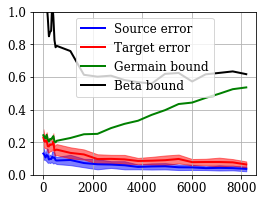

In [214]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for s in np.sort(D['sigma'].unique()):
    print('Sigma = %.5f' % s)
    
    
    stratum = D['sigma']==s
    ws = D[stratum]['Weightupdates']
    e_so = D[stratum]['train_germain']
    e_ta = D[stratum]['target_germain']
    e_so_std = D[stratum]['error_std']
    e_ta_std = D[stratum]['target_error_std']
    KL = D[stratum]['KL']
    gb = D[stratum]['germain_bound']
    bb = D[stratum]['beta_bound']       

    plt.figure(figsize=(9,6))
    plt.grid(zorder=-100)
        
    plt.plot(ws, e_so, label='Source error', lw=2, c='b')
    plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')
    
    plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
    plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')
    
    plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
    plt.plot(ws, bb, label='Beta bound', lw=2, c='k')
    
    plt.xlim(0, 1000)
    plt.ylim(0, 1.)
    
    
    plt.rc('font', size=12, family='serif')
    plt.figure(figsize=(4,3))
    plt.grid(zorder=-100)
    
    plt.plot(ws, e_so, label='Source error', lw=2, c='b')
    plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')
    
    plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
    plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')
    
    plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
    plt.plot(ws, bb, label='Beta bound', lw=2, c='k')
    plt.ylim(0, 1.)
    
    plt.legend()
    plt.show()

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,epsilon,checkpoint,delta,m_bound,m_target,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf
0,0,0.078133,0.175100,0.000000,0.074299,0.169057,0.012086,0.007669,0.002574,0.004041,...,0.01,1_0,0.05,63009,69990,None,0.165389,0.919886,0.130223,0.822505
0,0,0.130426,0.229395,0.000000,0.062370,0.140644,0.177502,0.136112,0.039014,0.050676,...,0.01,1_0,0.05,63009,69990,None,0.242852,1.199708,0.211255,0.774144
0,0,0.085449,0.186392,0.000000,0.071784,0.164029,0.044726,0.027330,0.009919,0.017901,...,0.01,1_0,0.05,63009,69990,None,0.178559,0.970304,0.149262,0.811195
0,45,0.120506,0.202861,0.558201,0.054230,0.110433,0.184856,0.132553,0.026965,0.037719,...,0.01,1_45,0.05,63009,69990,None,0.232309,1.063260,0.201205,0.688372
0,45,0.062783,0.143875,5.582011,0.059142,0.137207,0.013336,0.007281,0.000885,0.003791,...,0.01,1_45,0.05,63009,69990,None,0.144410,0.748138,0.108155,0.656577


Sigma = 0.00300


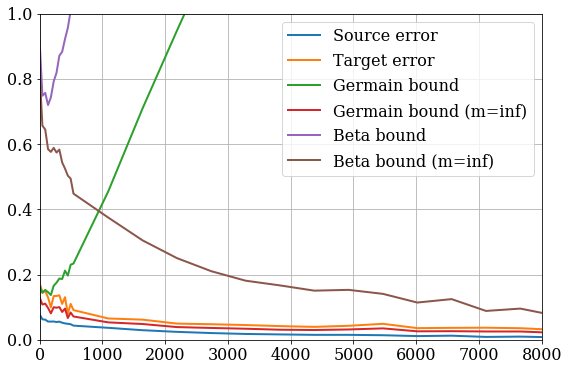

Sigma = 0.01000


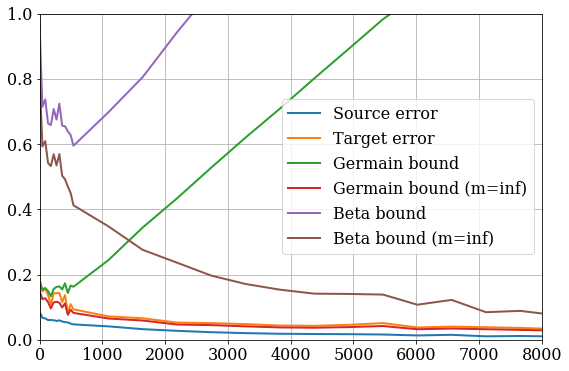

Sigma = 0.03000


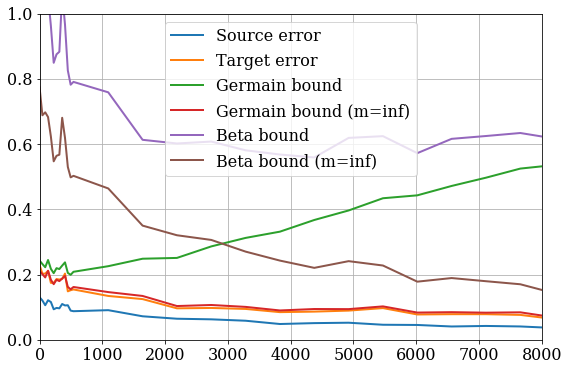

In [215]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for s in np.sort(D['sigma'].unique()):
    print('Sigma = %.5f' % s)
    
    
    stratum = D['sigma']==s
    ws = D[stratum]['Weightupdates']
    e_so = D[stratum]['train_germain']
    e_ta = D[stratum]['target_germain']
    e_so_std = D[stratum]['error_std']
    e_ta_std = D[stratum]['target_error_std']
    KL = D[stratum]['KL']
    gb = D[stratum]['germain_bound']
    gbi = D[stratum]['germain_bound_inf']
    bb = D[stratum]['beta_bound']       
    bbi = D[stratum]['beta_bound_inf']       

    plt.figure(figsize=(9,6))
    plt.grid(zorder=-100)
        
    plt.plot(ws, e_so, label='Source error', lw=2)    
    plt.plot(ws, e_ta, label='Target error', lw=2)    
    plt.plot(ws, gb, label='Germain bound', lw=2)
    plt.plot(ws, gbi, label='Germain bound (m=inf)', lw=2)
    plt.plot(ws, bb, label='Beta bound', lw=2)
    plt.plot(ws, bbi, label='Beta bound (m=inf)', lw=2)
    plt.xlim(0, 8000)
    plt.ylim(0, 1)
    
    plt.legend()
    plt.show()